# Romanos NN
Neste notebook vamos treinar uma *Rede Neural* simples para converter números para algorismos romanos.

## Dataset
O dataset é uma tabela contendo **4999** algorismos romanos e seu correspondente em algarismos indo-arábicos.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df = pd.read_csv("romanos.csv", sep="\t")
df.head()

,numero,romano
0,1,I
1,2,II
2,3,III
3,4,IV
4,5,V


In [3]:
df.tail()

,numero,romano
4994,4995,MMMMCMXCV
4995,4996,MMMMCMXCVI
4996,4997,MMMMCMXCVII
4997,4998,MMMMCMXCVIII
4998,4999,MMMMCMXCIX


## Preparação dos dados
O primeiro passo para treinar uma rede neural é a preparação de dados. Vamos criar `encodings` para a entrada e a saída dos dados.

A entrada de dados será uma array contendo o valor de cada número em binário (13 bits).

A saída de dados será uma array de 16 bytes contendo a string de saída (128 bytes).

In [4]:
df.loc[df["romano"].apply(len).sort_values(ascending=False).index[0]]

numero                4888
romano    MMMMDCCCLXXXVIII
Name: 4887, dtype: object

In [5]:
def encode_in(row):
    R = [int(x) for x in bin(row)[2:]]
    R = [0] * (13 - len(R)) + R
    return R
    
df["in"] = df["numero"].apply(encode_in)
df.head()

,numero,romano,in
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"


In [6]:
def decode_in(row):
    return int("".join([str(x) for x in row]), base=2)
    
df["in"].apply(decode_in)
df["in"].apply(decode_in) == df["numero"]
all(df["in"].apply(decode_in) == df["numero"])

True

In [7]:
def encode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    zeros = np.zeros((16, len(numerais))).astype(np.uint8)
    R = list(row)
    R = [numerais.index(letra) for letra in R]
    R += [len(numerais)-1] * (16 - len(R))
    zeros[np.arange(16), R] = 1
    return zeros.flatten()
    
df["out"] = df["romano"].apply(encode_out)
df.head()

,numero,romano,in,out
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
def decode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    return "".join([numerais[i] for i in row.reshape((16, -1)).argmax(axis=1)]).strip()

df["out"].apply(decode_out)
df["out"].apply(decode_out) == df["romano"]
all(df["out"].apply(decode_out) == df["romano"])

True

Após a preparação dos dados, vamos dividir o dataset em dois conjuntos, o conjunto de treino contendo 80% dos dados e o conjunto de teste contendo 20% dos dados.

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train = df_train.reset_index().drop(columns="index")
df_test = df_test.reset_index().drop(columns="index")

In [10]:
print("conjunto de treino: {} linhas".format(len(df_train)))
df_train.head()

conjunto de treino: 3999 linhas


,numero,romano,in,out
0,3786,MMMDCCLXXXVI,"[0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,2697,MMDCXCVII,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,106,CVI,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,211,CCXI,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,888,DCCCLXXXVIII,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [11]:
print("conjunto de teste: {} linhas".format(len(df_test)))
df_test.head()

conjunto de teste: 1000 linhas


,numero,romano,in,out
0,923,CMXXIII,"[0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,478,CDLXXVIII,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,4670,MMMMDCLXX,"[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,3801,MMMDCCCI,"[0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,2496,MMCDXCVI,"[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### Importante
- Extrair as características dos dados de entrada e saída
- Separar os conjuntos de treino e de teste

## Treinamento

As redes neurais realizam apenas três operações muito simples: 
  - MatMul
  - Bias Add
  - ACTIVATE !!!
  
![rede neural](Colored_neural_network.svg)

\begin{align}
\text{MatMul: }& h = W^t\cdotp X \\
\text{Bias Add: }& Z = W^t\cdotp X + b\\
\text{ACTIVATE!: }& A = f(W^t\cdotp X + b)\\
\end{align}

Para treinar uma rede, podemos comparar a saída da rede com a saída esperada e ajustar os pesos da matriz ***W*** e do vetor ***b*** de acordo com os erros. A técnica mais utilizada para isso é o **Backpropagation**.

Além disso, existem *otimizadores* que ajudam a manter a estabilidade do treino, além de diminuir o tempo necessário. Utilizaremos o **Adam** que ajusta alguns hiperparâmetros da rede automaticamente.

![adam](adam.png)

Com os dados prontos, podemos treinar as redes neurais. Vamos começar com uma rede pequena com apenas uma camada oculta:

In [12]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=13))
model.add(Dense(units=128, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________


A rede neural inicialmente "chuta" qualquer valor para a saída (acurácia ~50%). O texto gerado é aleatório.

In [13]:
def evaluate_model(model):
    res = model.evaluate(np.array(df_test["in"].values.tolist()), np.array(df_test["out"].values.tolist()))
    print("Custo: {}\nAcurácia: {}".format(*res))
evaluate_model(model)

1000/1000 [==============================] - 1s 802us/step
Custo: 0.6934310722351075
Acurácia: 0.512234375


In [14]:
def make_predictions(model):
    pred = model.predict(np.array(df_test["in"].values.tolist()))
    data = []
    for (_, row), p in zip(df_test.iterrows(), pred):
        _p = decode_out(p)
        data.append({
            "numero": row["numero"],
            "romano": row["romano"],
            "pred": _p,
            "match": row["romano"] == _p
        })
    return pd.DataFrame(data)
def evaluate_algorisms(model):
    df = make_predictions(model)
    print(df["match"].sum(), "acertos")
    return df

df_p0 = evaluate_algorisms(model)
df_p0.head()

0 acertos


,match,numero,pred,romano
0,False,923,VCLII V XDXMI XM,CMXXIII
1,False,478,VMLXL VCIMLDDDLD,CDLXXVIII
2,False,4670,VVXLX VMI LLILCD,MMMMDCLXX
3,False,3801,VCLLVV L XXICLD,MMMDCCCI
4,False,2496,VMLMVCVL MLX VLD,MMCDXCVI


Treinando o modelo por uma época (todos os ~3999 algorísmos) começamos a ver resultados mais coerentes:

In [15]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 3599 samples, validate on 400 samples
Epoch 1/1
3599/3599 [==============================] - 0s 84us/step - loss: 0.3892 - acc: 0.8786 - val_loss: 0.1981 - val_acc: 0.9323


In [16]:
df_p1 = evaluate_algorisms(model)
df_p1.head()

0 acertos


,match,numero,pred,romano
0,False,923,MMMCXX,CMXXIII
1,False,478,MMMCCX,CDLXXVIII
2,False,4670,MMMCCCX,MMMMDCLXX
3,False,3801,MMMCCX,MMMDCCCI
4,False,2496,MMMCCXX,MMCDXCVI


#### Underfit!!!
Neste caso, o modelo entende a estrutura geral da saída (não separar os algorísmos por exemplo), mas ainda não consegue prever os valores corretamente. Dizemos que este modelo tem um grande viés, e está em regime de **underfit**.


## Treinando mais épocas
Vamos treinar o mesmo modelo por mais 499 épocas:

In [17]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=499, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.1857 - acc: 0.9338 - val_loss: 0.1756 - val_acc: 0.9363
Epoch 2/499
3599/3599 [==============================] - 0s 63us/step - loss: 0.1700 - acc: 0.9377 - val_loss: 0.1640 - val_acc: 0.9390
Epoch 3/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.1596 - acc: 0.9400 - val_loss: 0.1561 - val_acc: 0.9406
Epoch 4/499
3599/3599 [==============================] - 0s 56us/step - loss: 0.1528 - acc: 0.9410 - val_loss: 0.1505 - val_acc: 0.9418
Epoch 5/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.1482 - acc: 0.9417 - val_loss: 0.1473 - val_acc: 0.9425
Epoch 6/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.1448 - acc: 0.9422 - val_loss: 0.1443 - val_acc: 0.9428
Epoch 7/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.1423 - acc: 0.9427 - val_loss: 0.1420 - val_acc: 0.9437
E

3599/3599 [==============================] - 0s 54us/step - loss: 0.1053 - acc: 0.9560 - val_loss: 0.1061 - val_acc: 0.9564
Epoch 61/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.1050 - acc: 0.9561 - val_loss: 0.1055 - val_acc: 0.9565
Epoch 62/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.1048 - acc: 0.9563 - val_loss: 0.1055 - val_acc: 0.9567
Epoch 63/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1044 - acc: 0.9565 - val_loss: 0.1049 - val_acc: 0.9566
Epoch 64/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1041 - acc: 0.9564 - val_loss: 0.1048 - val_acc: 0.9568
Epoch 65/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.1038 - acc: 0.9568 - val_loss: 0.1043 - val_acc: 0.9571
Epoch 66/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.1035 - acc: 0.9568 - val_loss: 0.1042 - val_acc: 0.9571
Epoch 67/499
3599/3599 [==============================

Epoch 120/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0923 - acc: 0.9617 - val_loss: 0.0946 - val_acc: 0.9608
Epoch 121/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0921 - acc: 0.9617 - val_loss: 0.0942 - val_acc: 0.9610
Epoch 122/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.0920 - acc: 0.9617 - val_loss: 0.0944 - val_acc: 0.9610
Epoch 123/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0918 - acc: 0.9619 - val_loss: 0.0939 - val_acc: 0.9608
Epoch 124/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0917 - acc: 0.9619 - val_loss: 0.0938 - val_acc: 0.9611
Epoch 125/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0915 - acc: 0.9619 - val_loss: 0.0942 - val_acc: 0.9606
Epoch 126/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0914 - acc: 0.9620 - val_loss: 0.0937 - val_acc: 0.9612
Epoch 127/499
3599/3599 [=========

3599/3599 [==============================] - 0s 62us/step - loss: 0.0858 - acc: 0.9642 - val_loss: 0.0891 - val_acc: 0.9628
Epoch 180/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0857 - acc: 0.9643 - val_loss: 0.0888 - val_acc: 0.9629
Epoch 181/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.0856 - acc: 0.9642 - val_loss: 0.0889 - val_acc: 0.9626
Epoch 182/499
3599/3599 [==============================] - 0s 56us/step - loss: 0.0856 - acc: 0.9642 - val_loss: 0.0889 - val_acc: 0.9629
Epoch 183/499
3599/3599 [==============================] - 0s 60us/step - loss: 0.0854 - acc: 0.9643 - val_loss: 0.0889 - val_acc: 0.9631
Epoch 184/499
3599/3599 [==============================] - 0s 56us/step - loss: 0.0854 - acc: 0.9643 - val_loss: 0.0889 - val_acc: 0.9627
Epoch 185/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0853 - acc: 0.9644 - val_loss: 0.0890 - val_acc: 0.9627
Epoch 186/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 48us/step - loss: 0.0811 - acc: 0.9663 - val_loss: 0.0853 - val_acc: 0.9646
Epoch 239/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0810 - acc: 0.9663 - val_loss: 0.0853 - val_acc: 0.9645
Epoch 240/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0810 - acc: 0.9663 - val_loss: 0.0852 - val_acc: 0.9647
Epoch 241/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0810 - acc: 0.9663 - val_loss: 0.0851 - val_acc: 0.9647
Epoch 242/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0809 - acc: 0.9663 - val_loss: 0.0855 - val_acc: 0.9646
Epoch 243/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0808 - acc: 0.9664 - val_loss: 0.0851 - val_acc: 0.9648
Epoch 244/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0807 - acc: 0.9664 - val_loss: 0.0848 - val_acc: 0.9646
Epoch 245/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 51us/step - loss: 0.0780 - acc: 0.9673 - val_loss: 0.0827 - val_acc: 0.9652
Epoch 298/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0779 - acc: 0.9674 - val_loss: 0.0829 - val_acc: 0.9657
Epoch 299/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0779 - acc: 0.9674 - val_loss: 0.0829 - val_acc: 0.9653
Epoch 300/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0778 - acc: 0.9674 - val_loss: 0.0831 - val_acc: 0.9656
Epoch 301/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0778 - acc: 0.9674 - val_loss: 0.0828 - val_acc: 0.9651
Epoch 302/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0776 - acc: 0.9675 - val_loss: 0.0829 - val_acc: 0.9651
Epoch 303/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0777 - acc: 0.9675 - val_loss: 0.0826 - val_acc: 0.9654
Epoch 304/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 49us/step - loss: 0.0756 - acc: 0.9683 - val_loss: 0.0812 - val_acc: 0.9662
Epoch 357/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0756 - acc: 0.9683 - val_loss: 0.0815 - val_acc: 0.9659
Epoch 358/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0755 - acc: 0.9684 - val_loss: 0.0810 - val_acc: 0.9664
Epoch 359/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0755 - acc: 0.9682 - val_loss: 0.0811 - val_acc: 0.9660
Epoch 360/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0755 - acc: 0.9682 - val_loss: 0.0810 - val_acc: 0.9658
Epoch 361/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0754 - acc: 0.9684 - val_loss: 0.0809 - val_acc: 0.9662
Epoch 362/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0754 - acc: 0.9683 - val_loss: 0.0813 - val_acc: 0.9663
Epoch 363/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 49us/step - loss: 0.0739 - acc: 0.9689 - val_loss: 0.0796 - val_acc: 0.9666
Epoch 416/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0738 - acc: 0.9689 - val_loss: 0.0796 - val_acc: 0.9668
Epoch 417/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0737 - acc: 0.9688 - val_loss: 0.0799 - val_acc: 0.9667
Epoch 418/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0737 - acc: 0.9688 - val_loss: 0.0796 - val_acc: 0.9667
Epoch 419/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0736 - acc: 0.9690 - val_loss: 0.0796 - val_acc: 0.9671
Epoch 420/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0737 - acc: 0.9690 - val_loss: 0.0794 - val_acc: 0.9670
Epoch 421/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0736 - acc: 0.9688 - val_loss: 0.0798 - val_acc: 0.9665
Epoch 422/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 62us/step - loss: 0.0723 - acc: 0.9695 - val_loss: 0.0787 - val_acc: 0.9677
Epoch 475/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0722 - acc: 0.9694 - val_loss: 0.0789 - val_acc: 0.9668
Epoch 476/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0722 - acc: 0.9695 - val_loss: 0.0782 - val_acc: 0.9672
Epoch 477/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0722 - acc: 0.9695 - val_loss: 0.0784 - val_acc: 0.9671
Epoch 478/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0722 - acc: 0.9696 - val_loss: 0.0781 - val_acc: 0.9672
Epoch 479/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0722 - acc: 0.9695 - val_loss: 0.0785 - val_acc: 0.9667
Epoch 480/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0721 - acc: 0.9696 - val_loss: 0.0784 - val_acc: 0.9665
Epoch 481/499
3599/3599 [=======================

In [18]:
evaluate_model(model)

1000/1000 [==============================] - 0s 16us/step
Custo: 0.07963809078931808
Acurácia: 0.967265625


In [19]:
df_p500 = evaluate_algorisms(model)
df_p500.head()

37 acertos


,match,numero,pred,romano
0,False,923,CMXXC,CMXXIII
1,False,478,CDLXXXI,CDLXXVIII
2,False,4670,MMMMDCLXIII,MMMMDCLXX
3,False,3801,MMMDCCCXXI,MMMDCCCI
4,False,2496,MMCXXI,MMCDXCVI


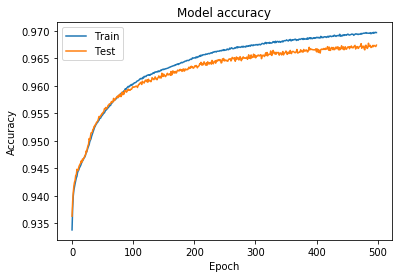

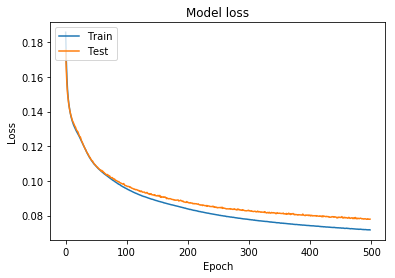

In [20]:
def plot_model(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot_model(history)

Treinando por mais épocas, conseguimos um modelo que entende o conceito dos algorismos, mas consegue acertar apenas 4% deles. Este parece ser o limite dessa arquitetura.

## Segunda Tentativa
Como um modelo pequeno não foi capaz de generalizar o problema, vamos criar um modelo mais profundo (10 camadas ocultas):

In [21]:
model2 = Sequential()
model2.add(Dense(units=128, activation='relu', input_dim=13))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [22]:
evaluate_model(model2)

1000/1000 [==============================] - 0s 118us/step
Custo: 0.6928495125770568
Acurácia: 0.52340625


In [23]:
df2_p0 = evaluate_algorisms(model2)
df2_p0.head()

0 acertos


,match,numero,pred,romano
0,False,923,MIC XIIDIIDDLLVL,CMXXIII
1,False,478,MIXCXIIICIMDVLVM,CDLXXVIII
2,False,4670,MICCXIVXCIMDLMVL,MMMMDCLXX
3,False,3801,MIX XIIIIILDVLVM,MMMDCCCI
4,False,2496,MIXMXIIDIILDDDVM,MMCDXCVI


In [24]:
history2 = model2.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=500, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/500
3599/3599 [==============================] - 1s 205us/step - loss: 0.2448 - acc: 0.9048 - val_loss: 0.1849 - val_acc: 0.9301
Epoch 2/500
3599/3599 [==============================] - 0s 113us/step - loss: 0.1838 - acc: 0.9297 - val_loss: 0.1668 - val_acc: 0.9355
Epoch 3/500
3599/3599 [==============================] - 0s 116us/step - loss: 0.1538 - acc: 0.9373 - val_loss: 0.1484 - val_acc: 0.9369
Epoch 4/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.1385 - acc: 0.9408 - val_loss: 0.1373 - val_acc: 0.9409
Epoch 5/500
3599/3599 [==============================] - 0s 97us/step - loss: 0.1338 - acc: 0.9422 - val_loss: 0.1360 - val_acc: 0.9415
Epoch 6/500
3599/3599 [==============================] - 0s 97us/step - loss: 0.1315 - acc: 0.9429 - val_loss: 0.1308 - val_acc: 0.9430
Epoch 7/500
3599/3599 [==============================] - 0s 97us/step - loss: 0.1275 - acc: 0.9451 - val_loss: 0.1249 - val_acc: 0.94

3599/3599 [==============================] - 0s 95us/step - loss: 0.0540 - acc: 0.9755 - val_loss: 0.0662 - val_acc: 0.9713
Epoch 61/500
3599/3599 [==============================] - 0s 96us/step - loss: 0.0537 - acc: 0.9755 - val_loss: 0.0685 - val_acc: 0.9709
Epoch 62/500
3599/3599 [==============================] - 0s 95us/step - loss: 0.0538 - acc: 0.9755 - val_loss: 0.0636 - val_acc: 0.9717
Epoch 63/500
3599/3599 [==============================] - 0s 96us/step - loss: 0.0532 - acc: 0.9758 - val_loss: 0.0710 - val_acc: 0.9694
Epoch 64/500
3599/3599 [==============================] - 0s 95us/step - loss: 0.0563 - acc: 0.9746 - val_loss: 0.0657 - val_acc: 0.9714
Epoch 65/500
3599/3599 [==============================] - 0s 96us/step - loss: 0.0512 - acc: 0.9765 - val_loss: 0.0641 - val_acc: 0.9726
Epoch 66/500
3599/3599 [==============================] - 0s 98us/step - loss: 0.0523 - acc: 0.9763 - val_loss: 0.0688 - val_acc: 0.9707
Epoch 67/500
3599/3599 [==============================

3599/3599 [==============================] - 0s 123us/step - loss: 0.0408 - acc: 0.9811 - val_loss: 0.0675 - val_acc: 0.9726
Epoch 120/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0409 - acc: 0.9810 - val_loss: 0.0698 - val_acc: 0.9724
Epoch 121/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.0419 - acc: 0.9806 - val_loss: 0.0668 - val_acc: 0.9722
Epoch 122/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0420 - acc: 0.9807 - val_loss: 0.0693 - val_acc: 0.9721
Epoch 123/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0424 - acc: 0.9806 - val_loss: 0.0696 - val_acc: 0.9720
Epoch 124/500
3599/3599 [==============================] - 0s 100us/step - loss: 0.0427 - acc: 0.9805 - val_loss: 0.0781 - val_acc: 0.9687
Epoch 125/500
3599/3599 [==============================] - 0s 99us/step - loss: 0.0445 - acc: 0.9798 - val_loss: 0.0677 - val_acc: 0.9722
Epoch 126/500
3599/3599 [=================

3599/3599 [==============================] - 0s 97us/step - loss: 0.0338 - acc: 0.9850 - val_loss: 0.0871 - val_acc: 0.9702
Epoch 179/500
3599/3599 [==============================] - 0s 98us/step - loss: 0.0359 - acc: 0.9842 - val_loss: 0.0858 - val_acc: 0.9696
Epoch 180/500
3599/3599 [==============================] - 0s 98us/step - loss: 0.0338 - acc: 0.9852 - val_loss: 0.0891 - val_acc: 0.9701
Epoch 181/500
3599/3599 [==============================] - 0s 104us/step - loss: 0.0330 - acc: 0.9853 - val_loss: 0.0864 - val_acc: 0.9710
Epoch 182/500
3599/3599 [==============================] - 0s 105us/step - loss: 0.0316 - acc: 0.9860 - val_loss: 0.0919 - val_acc: 0.9695
Epoch 183/500
3599/3599 [==============================] - 0s 121us/step - loss: 0.0367 - acc: 0.9840 - val_loss: 0.0871 - val_acc: 0.9701
Epoch 184/500
3599/3599 [==============================] - 0s 105us/step - loss: 0.0323 - acc: 0.9859 - val_loss: 0.0894 - val_acc: 0.9707
Epoch 185/500
3599/3599 [===================

3599/3599 [==============================] - 0s 120us/step - loss: 0.0236 - acc: 0.9897 - val_loss: 0.1153 - val_acc: 0.9703
Epoch 238/500
3599/3599 [==============================] - 0s 113us/step - loss: 0.0238 - acc: 0.9899 - val_loss: 0.1142 - val_acc: 0.9705
Epoch 239/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0216 - acc: 0.9907 - val_loss: 0.1157 - val_acc: 0.9705
Epoch 240/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.0206 - acc: 0.9912 - val_loss: 0.1208 - val_acc: 0.9705
Epoch 241/500
3599/3599 [==============================] - 0s 113us/step - loss: 0.0221 - acc: 0.9907 - val_loss: 0.1193 - val_acc: 0.9711
Epoch 242/500
3599/3599 [==============================] - 0s 113us/step - loss: 0.0209 - acc: 0.9911 - val_loss: 0.1235 - val_acc: 0.9704
Epoch 243/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0242 - acc: 0.9898 - val_loss: 0.1188 - val_acc: 0.9703
Epoch 244/500
3599/3599 [================

3599/3599 [==============================] - 0s 103us/step - loss: 0.0240 - acc: 0.9907 - val_loss: 0.1419 - val_acc: 0.9682
Epoch 297/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0205 - acc: 0.9916 - val_loss: 0.1271 - val_acc: 0.9712
Epoch 298/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0174 - acc: 0.9927 - val_loss: 0.1478 - val_acc: 0.9689
Epoch 299/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0131 - acc: 0.9946 - val_loss: 0.1522 - val_acc: 0.9702
Epoch 300/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0111 - acc: 0.9955 - val_loss: 0.1557 - val_acc: 0.9704
Epoch 301/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0130 - acc: 0.9947 - val_loss: 0.1666 - val_acc: 0.9700
Epoch 302/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0215 - acc: 0.9915 - val_loss: 0.1510 - val_acc: 0.9689
Epoch 303/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0091 - acc: 0.9964 - val_loss: 0.1819 - val_acc: 0.9695
Epoch 356/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0085 - acc: 0.9966 - val_loss: 0.1846 - val_acc: 0.9704
Epoch 357/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0144 - acc: 0.9945 - val_loss: 0.1786 - val_acc: 0.9692
Epoch 358/500
3599/3599 [==============================] - 0s 100us/step - loss: 0.0257 - acc: 0.9907 - val_loss: 0.1496 - val_acc: 0.9685
Epoch 359/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0147 - acc: 0.9941 - val_loss: 0.1658 - val_acc: 0.9696
Epoch 360/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0098 - acc: 0.9962 - val_loss: 0.1744 - val_acc: 0.9696
Epoch 361/500
3599/3599 [==============================] - 0s 100us/step - loss: 0.0089 - acc: 0.9966 - val_loss: 0.1859 - val_acc: 0.9695
Epoch 362/500
3599/3599 [================

3599/3599 [==============================] - 0s 106us/step - loss: 0.0073 - acc: 0.9973 - val_loss: 0.1961 - val_acc: 0.9699
Epoch 415/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0049 - acc: 0.9983 - val_loss: 0.2088 - val_acc: 0.9692
Epoch 416/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.0042 - acc: 0.9986 - val_loss: 0.2090 - val_acc: 0.9707
Epoch 417/500
3599/3599 [==============================] - 0s 105us/step - loss: 0.0030 - acc: 0.9990 - val_loss: 0.2225 - val_acc: 0.9701
Epoch 418/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0054 - acc: 0.9981 - val_loss: 0.2241 - val_acc: 0.9688
Epoch 419/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0318 - acc: 0.9906 - val_loss: 0.1833 - val_acc: 0.9646
Epoch 420/500
3599/3599 [==============================] - 0s 105us/step - loss: 0.0371 - acc: 0.9872 - val_loss: 0.1427 - val_acc: 0.9662
Epoch 421/500
3599/3599 [================

3599/3599 [==============================] - 0s 107us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.2227 - val_acc: 0.9702
Epoch 474/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.2336 - val_acc: 0.9698
Epoch 475/500
3599/3599 [==============================] - 0s 104us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.2426 - val_acc: 0.9695
Epoch 476/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.2408 - val_acc: 0.9696
Epoch 477/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.0114 - acc: 0.9962 - val_loss: 0.2241 - val_acc: 0.9674
Epoch 478/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.0332 - acc: 0.9892 - val_loss: 0.1724 - val_acc: 0.9669
Epoch 479/500
3599/3599 [==============================] - 0s 105us/step - loss: 0.0205 - acc: 0.9926 - val_loss: 0.1713 - val_acc: 0.9689
Epoch 480/500
3599/3599 [================

In [25]:
evaluate_model(model2)

1000/1000 [==============================] - 0s 24us/step
Custo: 0.18085679912567137
Acurácia: 0.9678515625


In [26]:
df2_p500 = evaluate_algorisms(model2)
df2_p500.head()

48 acertos


,match,numero,pred,romano
0,False,923,CMXXII,CMXXIII
1,False,478,CDLXXVII,CDLXXVIII
2,False,4670,MMMMDCLXVI,MMMMDCLXX
3,False,3801,MMMDCCC,MMMDCCCI
4,False,2496,MMDXII,MMCDXCVI


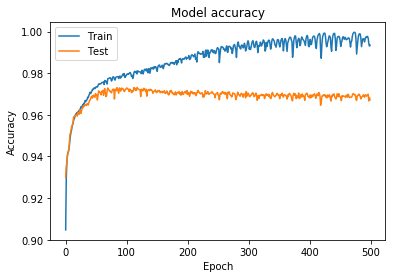

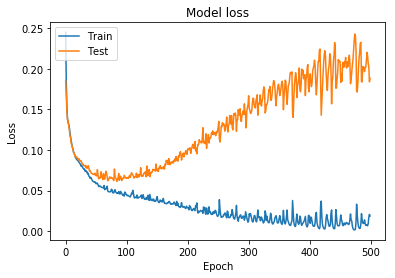

In [27]:
plot_model(history2)

#### Overfit!!
Dessa vez o modelo consegue acertar todo o conjunto de treino mas não o conjunto de testes, o modelo apenas decorou os algorismos do conjunto de treino mas não consegue generalizar o problema. Dizemos que este modelo possui uma grande variância e está em regime de **overfit**.

## Terceira tentativa
Por último, vamos tentar uma rede com 4 camadas ocultas, mas com mais nós em cada camada para extrair mais características.

In [28]:
model3 = Sequential()
model3.add(Dense(units=1024, activation='relu', input_dim=13))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=128, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              14336     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
Total params: 703,360
Trainable params: 703,360
Non-trainable params: 0
_________________________________________________________________


In [29]:
history3 = model3.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=120, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/120
3599/3599 [==============================] - 1s 190us/step - loss: 0.2101 - acc: 0.9221 - val_loss: 0.1446 - val_acc: 0.9422
Epoch 2/120
3599/3599 [==============================] - 0s 93us/step - loss: 0.1347 - acc: 0.9444 - val_loss: 0.1296 - val_acc: 0.9457
Epoch 3/120
3599/3599 [==============================] - 0s 92us/step - loss: 0.1208 - acc: 0.9505 - val_loss: 0.1136 - val_acc: 0.9525
Epoch 4/120
3599/3599 [==============================] - 0s 109us/step - loss: 0.1113 - acc: 0.9535 - val_loss: 0.1059 - val_acc: 0.9567
Epoch 5/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.1038 - acc: 0.9563 - val_loss: 0.1023 - val_acc: 0.9562
Epoch 6/120
3599/3599 [==============================] - 0s 90us/step - loss: 0.0991 - acc: 0.9581 - val_loss: 0.0982 - val_acc: 0.9590
Epoch 7/120
3599/3599 [==============================] - 0s 100us/step - loss: 0.0958 - acc: 0.9596 - val_loss: 0.0935 - val_acc: 0.960

3599/3599 [==============================] - 0s 94us/step - loss: 0.0154 - acc: 0.9941 - val_loss: 0.0389 - val_acc: 0.9859
Epoch 61/120
3599/3599 [==============================] - 0s 90us/step - loss: 0.0161 - acc: 0.9938 - val_loss: 0.0439 - val_acc: 0.9846
Epoch 62/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.0176 - acc: 0.9930 - val_loss: 0.0471 - val_acc: 0.9838
Epoch 63/120
3599/3599 [==============================] - 0s 93us/step - loss: 0.0144 - acc: 0.9945 - val_loss: 0.0408 - val_acc: 0.9854
Epoch 64/120
3599/3599 [==============================] - 0s 92us/step - loss: 0.0141 - acc: 0.9947 - val_loss: 0.0380 - val_acc: 0.9856
Epoch 65/120
3599/3599 [==============================] - 0s 90us/step - loss: 0.0126 - acc: 0.9954 - val_loss: 0.0391 - val_acc: 0.9860
Epoch 66/120
3599/3599 [==============================] - 0s 96us/step - loss: 0.0118 - acc: 0.9958 - val_loss: 0.0412 - val_acc: 0.9855
Epoch 67/120
3599/3599 [==============================

3599/3599 [==============================] - 0s 94us/step - loss: 6.0866e-04 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9878
Epoch 120/120
3599/3599 [==============================] - 0s 91us/step - loss: 4.8652e-04 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9880


In [30]:
evaluate_model(model3)

1000/1000 [==============================] - 0s 18us/step
Custo: 0.054135045170784
Acurácia: 0.9869609375


In [31]:
df3_p120 = evaluate_algorisms(model3)
df3_p120.head()

451 acertos


,match,numero,pred,romano
0,False,923,CMXXII,CMXXIII
1,False,478,CDLXXVII,CDLXXVIII
2,True,4670,MMMMDCLXX,MMMMDCLXX
3,False,3801,MMMDCCXII,MMMDCCCI
4,False,2496,MMCDXCV,MMCDXCVI


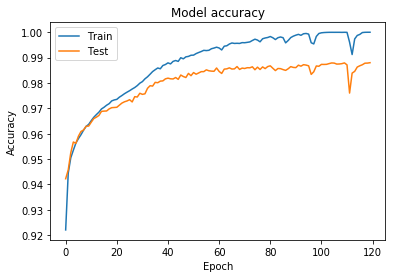

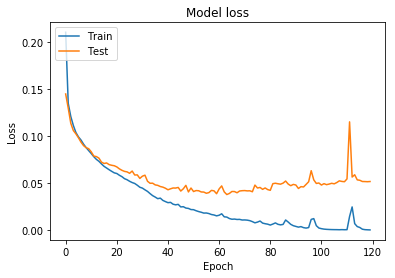

In [32]:
plot_model(history3)

#### Certin!!!
Encontrar os parâmetros ótimos para cada problema é um processo iterativo e requer paciência e experiência.

## Importante
- Cada "neurônio" é muito simples (Matmul, bias add, ACTIVATE!)
- Backpropagation
- Escolha da arquitetura e hiperparâmetros (camadas, ativações, otimizador)
- **Escolha do custo**
- RNNs provavelmente conseguem 100% neste dataset
### - ML IS FUN KIDS!

In [45]:
def predict(n):
    n_enc = encode_in(n)
    print("encode n: {}".format(n_enc))
    pred = model3.predict(np.array([n_enc]))
    print("pred enc_n: {}".format(pred.round(3).reshape((16, -1))))
    out = decode_out(pred)
    print("decode pred: {}".format(out))
    return out
predict(666)

encode n: [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
pred enc_n: [[0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.013 0.985 0.    0.    0.    0.    0.    0.   ]
 [0.997 0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]
decode pred: DCLXVI


'DCLXVI'